# Link Prediction using Node2Vec

Copyright @ 2020 **ABCOM Information Systems Pvt. Ltd.** 
All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

See the License for the specific language governing permissions and limitations under the License.

# Pre-requisite

Continuation of the previous project - [An In-depth Guide to Social Network Analysis](http://education.abcom.com/an-in-depth-guide-to-social-network-analysis/)


# Project

## Importing required libraries

In [ ]:
import random
from tqdm import tqdm
import networkx as nx
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

## Download output files created in part-1

In [ ]:
!wget https://github.com/abcom-mltutorials/Facebook-Social-Network-Analysis/archive/master.zip -P "/content"
ZipFile("/content/master.zip").extractall("/content/")

--2020-10-25 12:35:39--  https://github.com/ArkDy1312/Facebook-Social-Network-Analysis-Project/archive/master.zip
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ArkDy1312/Facebook-Social-Network-Analysis-Project/zip/master [following]
--2020-10-25 12:35:40--  https://codeload.github.com/ArkDy1312/Facebook-Social-Network-Analysis-Project/zip/master
Resolving codeload.github.com (codeload.github.com)... 52.193.111.178
Connecting to codeload.github.com (codeload.github.com)|52.193.111.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/master.zip.1’

master.zip.1            [   <=>              ]   1.35M  3.17MB/s    in 0.4s    

2020-10-25 12:35:40 (3.17 MB/s) - ‘/content/master.zip.1’ saved [1417240]



Retrieve the graph and 'fb' dataframe

In [ ]:
# We had generated these two files in part-1

# graph
G = nx.read_gpickle('/content/Facebook-Social-Network-Analysis-Project-master/Graph.pickle')
# fb dataframe
fb = pd.read_csv('/content/Facebook-Social-Network-Analysis-Project-master/fb.csv', index_col=[0])

In [ ]:
print(nx.info(G))

Name: Facebook SNA Graph
Type: Graph
Number of nodes: 1295
Number of edges: 18321
Average degree:  28.2950


In [ ]:
fb

,Node 1,Node 2
0,2,116
1,2,226
2,2,326
3,3,25
4,3,67
...,...,...
18316,3926,3938
18317,3926,3966
18318,3930,3938
18319,3938,3966


## Data rocessing

Create an adjacency matrix

In [ ]:
# get a list of nodes in our graph
l = list(G.nodes())

# create adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = l)

print(str(adj_G.shape)+'\n')
adj_G

(1295, 1295)



matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Get non-existing edges/node-pairs from the adjacency matrix

In [ ]:

# get all node pairs which don't have an edge
non_existing_edges = []

# traverse adjacency matrix 
offset = 0
for i in tqdm(range(adj_G.shape[0])):
    for j in range(offset,adj_G.shape[1]):
        if i != j:
            if adj_G[i,j] == 0:
                    non_existing_edges.extend([(l[i],l[j])])

    offset = offset + 1

100%|██████████| 1295/1295 [00:01<00:00, 900.52it/s] 


In [ ]:
# print few non_existing edges
non_existing_edges[:5]

[(2, 3), (2, 7), (2, 10), (2, 13), (2, 16)]

Select partial set of non-existing edges for balancing dataset 

In [ ]:
len(non_existing_edges)

819544

In [ ]:
# Ramdomly select 4000 non-existing edges
nodes_4000 = sorted(random.sample(non_existing_edges, k=40000))

Find the node pairs having a path between them

In [ ]:
non_existing_edges = [(i[0],i[1]) for i in tqdm(nodes_4000) if nx.has_path(G, i[0], i[1])]

100%|██████████| 40000/40000 [00:25<00:00, 1564.09it/s]


In [ ]:
non_existing_edges[:5]

[(2, 7), (2, 25), (2, 55), (2, 119), (2, 146)]

Create a dataframe of the node pairs in 'non_existing_edges'


In [ ]:
df1 = pd.DataFrame(data = non_existing_edges, columns =['Node 1', 'Node 2'])

# create a column 'Connection' with default 0 (no-connection)
df1['Connection'] = 0

df1.head()

,Node 1,Node 2,Connection
0,2,7,0
1,2,25,0
2,2,55,0
3,2,119,0
4,2,146,0


Getting the removable edges

In [ ]:
# Create a list of all indices of the node pairs in the fb dataframe, 
# which when removed won’t change the structure of our graph

# create a copy
fb_temp = fb.copy()

# for storing removable edges
removable_edges_indices = []

# number of connected components and nodes of G
ncc = nx.number_connected_components(G)
number_of_nodes = len(G.nodes)

# for each node pair we will be removing a node pair and creating a new graph, 
# and check if the number of connected components and the number of nodes 
# are the same as the original graph
for i in tqdm(fb.index.values):
    
       # remove a node pair and build a new graph
    G1 = nx.from_pandas_edgelist(fb_temp.drop(index= i), "Node 1", "Node 2", 
                                 create_using=nx.Graph())
    
       # If the number of connected components remain same as the original
       # graph we won't remove the edge
    if (nx.number_connected_components(G1) == ncc) and (len(G1.nodes) == number_of_nodes):
        removable_edges_indices.append(i)

        # drop the edge, so that for the next iteration the next G1 
        # is created without this edge 
        fb_temp = fb_temp.drop(index = i)


100%|██████████| 18321/18321 [07:30<00:00, 40.68it/s] 


In [ ]:
# print few items
removable_edges_indices[:5]

[0, 1, 3, 4, 5]

Create a dataframe with all the removable edges

In [ ]:
# get node pairs in fb dataframe with indices in removable_edges_indices
df2 = fb.loc[removable_edges_indices]

# create a column 'Connection' and assign default value of 1 (connected nodes)
df2['Connection'] = 1

df2.head()

,Node 1,Node 2,Connection
0,2,116,1
1,2,226,1
3,3,25,1
4,3,67,1
5,3,142,1


Combining df2 (removable edges) and df1 (non_existing edges) 

In [ ]:
df1 = df1.append(df2[['Node 1', 'Node 2', 'Connection']], 
                 ignore_index=True)
df1.head()

,Node 1,Node 2,Connection
0,2,7,0
1,2,25,0
2,2,55,0
3,2,119,0
4,2,146,0


Create subset of fb

In [ ]:
df3 = fb.drop(index=df2.index.values)

# we can assume that at a previous point of time node pairs 
# in 'df3' were the only node pairs with an edge between them, 
# such that in the future, node pairs in 'df1' with 
# 'Connection' = 1 will have a new edge
# while node pairs in 'df1' with 'Connection' = 0 
# means the node pairs don't have an edge between them 
# in our assumed future

df3.head()

,Node 1,Node 2
2,2,326
9,3,323
16,7,347
22,10,323
40,13,342


Create a graph ‘G_new’ with dataframe ‘df3’ consisting of node pairs assumed to be existing at previous point of time


In [ ]:
G_new = nx.from_pandas_edgelist(df3, "Node 1", "Node 2", 
                                create_using=nx.Graph())

print(nx.info(G_new))

Name: 
Type: Graph
Number of nodes: 1295
Number of edges: 1292
Average degree:   1.9954


## Model Building

Use Node2Vec for generating features

In [ ]:
!pip install node2vec

Create Node2Vec model with features of the nodes in graph 'G_new'

In [ ]:
from node2vec import Node2Vec

# Generating walks
node2vec = Node2Vec(G_new, dimensions=100, walk_length=16, num_walks=50)

# training the node2vec model
n2v_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


Generate edge/node pair features using node2vec model

In [ ]:
#adding up the features of the each node of a node pair 'df1' to generate the features of an edge/node pair
#storing all the features in a list

edge_features = [(n2v_model[str(i)]+n2v_model[str(j)]) 
for i,j in zip(df1['Node 1'], df1['Node 2'])]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


Import necessary libraries to create the ML model


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, auc, roc_curve, roc_auc_score,confusion_matrix

#features    
X = np.array(edge_features)    

#target
y = df1['Connection']

Split X and y into training and test data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

# GridSearchCV
Apply GridSearchCV on different ML classifiers to find the best model along with its best parameters

### Random Forest

In [ ]:
#classifier
clf1 = RandomForestClassifier()

# parameters
param = {'n_estimators' : [10,50,100], 'max_depth' : [5,10,15]}

# model
grid_clf_acc1 = GridSearchCV(clf1, param_grid = param)

# train the model
grid_clf_acc1.fit(X_train, y_train)

print('Grid best parameter (max. accuracy): ', grid_clf_acc1.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc1.best_score_)

# alternative metric to optimize over grid parameters: AUC
grid_clf_auc1 = GridSearchCV(clf1, param_grid = param, scoring = 'roc_auc')
grid_clf_auc1.fit(X_train, y_train)
predict_proba = grid_clf_auc1.predict_proba(X_test)[:,1]

print('Test set AUC: ', roc_auc_score(y_test, predict_proba))
print('Grid best parameter (max. AUC): ', grid_clf_auc1.best_params_)
print('Grid best score (AUC): ', grid_clf_auc1.best_score_)

Grid best parameter (max. accuracy):  {'max_depth': 15, 'n_estimators': 100}
Grid best score (accuracy):  0.8959887616426038
Test set AUC:  0.9576894016807131
Grid best parameter (max. AUC):  {'max_depth': 15, 'n_estimators': 100}
Grid best score (AUC):  0.9557946887229466


### Gradient Boost

In [ ]:
# classifier
clf2 = GradientBoostingClassifier()

# parameters
param = {'learning_rate' : [.05,.1]}

# model
grid_clf_acc2 = GridSearchCV(clf2, param_grid = param)

# train the model
grid_clf_acc2.fit(X_train, y_train)

print('Grid best parameter (max. accuracy): ', grid_clf_acc2.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc2.best_score_)

# alternative metric to optimize over grid parameters: AUC
grid_clf_auc2 = GridSearchCV(clf2, param_grid = param, scoring = 'roc_auc')
grid_clf_auc2.fit(X_train, y_train)
predict_proba = grid_clf_auc2.predict_proba(X_test)[:,1]

print('Test set AUC: ', roc_auc_score(y_test, predict_proba))
print('Grid best parameter (max. AUC): ', grid_clf_auc2.best_params_)
print('Grid best score (AUC): ', grid_clf_auc2.best_score_)

Grid best parameter (max. accuracy):  {'learning_rate': 0.1}
Grid best score (accuracy):  0.8519738661485189
Test set AUC:  0.8918467910170673
Grid best parameter (max. AUC):  {'learning_rate': 0.1}
Grid best score (AUC):  0.8931222841629047


## MLP Classifier (A Neural Network Classifier)

In [ ]:
# classifier
clf3 = MLPClassifier(max_iter=1000)

# scaling training and test sets
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# parameters
param = {'hidden_layer_sizes' : [10,100,[10,10]], 'activation' : ['tanh','relu'], 'solver' : ['adam','lbfgs']}

# model
grid_clf_acc3 = GridSearchCV(clf3, param_grid = param)

# train the model
grid_clf_acc3.fit(X_train_scaled, y_train)

print('Grid best parameter (max. accuracy): ', grid_clf_acc3.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc3.best_score_)

# alternative metric to optimize over grid parameters: AUC
grid_clf_auc3 = GridSearchCV(clf3, param_grid = param, scoring = 'roc_auc')
grid_clf_auc3.fit(X_train_scaled, y_train)
predict_proba = grid_clf_auc3.predict_proba(X_test_scaled)[:,1]

print('Test set AUC: ', roc_auc_score(y_test, predict_proba))
print('Grid best parameter (max. AUC): ', grid_clf_auc3.best_params_)
print('Grid best score (AUC): ', grid_clf_auc3.best_score_)

Grid best parameter (max. accuracy):  {'activation': 'tanh', 'hidden_layer_sizes': 100, 'solver': 'lbfgs'}
Grid best score (accuracy):  0.9021071068084228
Test set AUC:  0.956993136659119
Grid best parameter (max. AUC):  {'activation': 'relu', 'hidden_layer_sizes': 100, 'solver': 'adam'}
Grid best score (AUC):  0.9512847728843005


#Choosing Best Model 
MLP Classifier with scoring ‘roc_auc’


In [ ]:
# MLP Classifier with scoring ‘roc_auc’, grid_clf_auc3, 
# gives the best accuracy hence we choose this as our final model

# get predictions of our test data
pred = grid_clf_auc3.predict(X_test_scaled)

pred[:5]

array([0, 0, 0, 0, 1])

##Accuracy Score

In [ ]:
accuracy_score(pred,y_test)

0.9049050632911393

##Confusion Matrix 

In [ ]:
confusion_matrix(pred,y_test)

array([[7851,  617],
       [ 585, 3587]])

## Roc_auc score
Find the ROC_AUC score and plot the ROC Curve

Text(0, 0.5, 'True Positive Rate')

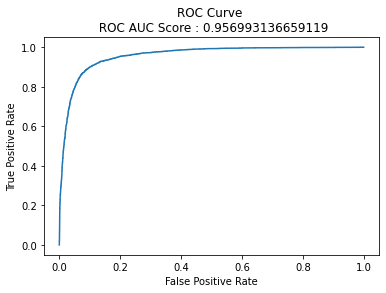

In [ ]:
predict_proba = grid_clf_auc3.predict_proba(X_test_scaled)[:,1]

false_positive_rate,true_positive_rate,_ = roc_curve(y_test, predict_proba)
roc_auc_score = auc(false_positive_rate,true_positive_rate)

#plotting
plt.plot(false_positive_rate,true_positive_rate)
plt.title(f'ROC Curve \n ROC AUC Score : {roc_auc_score}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Inference

In [ ]:
df1.head()

,Node 1,Node 2,Connection
0,2,7,0
1,2,25,0
2,2,55,0
3,2,119,0
4,2,146,0


In [ ]:
# from the above dataframe let's choose the nodes 2 and 146
# node pair (2,146) is at index 4, hence it's features

print(f' ({df1.iloc[4,0]},{df1.iloc[4,1]}) node pair features : {X[4]}')

# its position in X_train
print(f'Index of ({df1.iloc[4,0]},{df1.iloc[4,1]}) node pair in X_train : {np.where(X_train == X[4])[0][1]}')

 (2,146) node pair features : [-0.31974825  0.4454072  -0.56286263 -0.4206472   0.12306979  0.42737707
  1.5730785   0.3797015  -0.7960592   0.0442833  -0.1508733  -0.25716537
  0.04225296  0.3748195   0.72062814  0.61161005  0.04155549 -0.18565042
 -0.6799878   0.8175075   0.43788424  0.47371352  0.4174336  -0.17008828
  0.24093041  0.2562692  -0.44319597  0.61125034  0.8676627  -0.81734127
  1.0023162   0.11690486  0.08506802 -0.74477404 -0.29988915  0.13117796
 -0.5888928  -0.12368403  0.8263618   0.26192126 -0.04717672  0.5067867
 -0.11612257  0.5371035   0.8556694   0.34915298 -1.1659813   0.11113331
  1.1618596  -0.58864754  0.02775763 -0.09294853  0.21387857 -0.45490015
  0.6147701  -1.2038474   0.19944236  0.20778471  0.55409163  0.11599523
 -0.06365734 -0.16141433 -0.42084694 -0.33672625 -0.19359915  1.205441
  0.582776    0.5858595  -1.600161    0.9918225  -1.0026368  -0.73573154
 -0.1321021  -0.24353579  0.08773118  0.00299299 -0.01118031 -0.00592104
  1.1947114   0.37539566

In [ ]:
# probability of the two nodes forming a link or edge
# we will be using the values from X_train_scaled since 
# we have used the scaled version to train our model
predict_proba = grid_clf_auc3.predict_proba(X_train_scaled[np.where(X_train == X[4])[0][1]].reshape(1,-1))[:,1]

print(f'Probability of nodes {df1.iloc[4,0]} and {df1.iloc[4,1]} to form a link is : {float(predict_proba)*100 : .2f}%')

Probability of nodes 2 and 146 to form a link is :  9.09%


Saving dataset for part-3

In [ ]:
df1.to_csv('/content/Facebook-Social-Network-Analysis-Project-master/df1.csv, index=False')